###############################################################################

# Graph Neural Network Model Introduction 

################################################################################

In [1]:
# Step 1 : Environment Preparation 
!pip install torch torch-geometric rdkit-pypi networkx matplotlib


In [2]:
import torch 
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem


In [5]:
import torch
print(torch.__version__)  
print(hasattr(torch.utils._pytree, "register_pytree_node"))  # Must be True

import torch_geometric
from torch_geometric.data import Data
print("PyG OK")


2.2.2+cu121
True


/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops10zeros_like4callERKNS_6TensorEN3c108optionalINS5_10ScalarTypeEEENS6_INS5_6LayoutEEENS6_INS5_6DeviceEEENS6_IbEENS6_INS5_12MemoryFormatEEE
  import torch_geometric.typing
/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its

PyG OK


In [3]:

from torch_geometric.data import Data

/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops10zeros_like4callERKNS_6TensorEN3c108optionalINS5_10ScalarTypeEEENS6_INS5_6LayoutEEENS6_INS5_6DeviceEEENS6_IbEENS6_INS5_12MemoryFormatEEE
  import torch_geometric.typing
/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  import torch_geometric.typing
/home/omid/miniconda3/envs/chemenv/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its

In [8]:

######################################################################
# Step 1 : Define a function to ocncert SMILES to graph data structure
######################################################################

In [6]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)

    node_features = []
    edge_index = []

    for atom in mol.GetAtoms():
        node_features.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetHybridization().real,
            atom.GetNumImplicitHs(),
            atom.GetFormalCharge(),
            atom.GetIsAromatic(),
            atom.GetMass(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            atom.GetChiralTag().real,
            atom.GetTotalValence(),
            atom.GetNumExplicitHs(),
        ])

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])

    return Data(
        x=torch.tensor(node_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    )   

data = smiles_to_graph("CC(=O)OC1=CC=CC=C1C(=O)O")
print(" Input to the GNN is:", data)

 Input to the GNN is: Data(x=[21, 12], edge_index=[2, 42])


In [10]:
################################################################
#Step 2 : Define the GNN model architecture using KAN layers
################################################################

In [20]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCN2Conv,global_mean_pool

In [24]:
# GNN Design and Architecture for the Graph Encoder

class Simple_GNN(nn.Module):
    def __init__(self,in_dim):
        super().__init__()

        self.conv1 = GCN2Conv(in_dim,64)
        self.conv2 = GCN2Conv(64,128)

    def forward(self,x,edge_index,batch):   
        x = F.relu(self.conv1(x,edge_index))
        x = F.relu(self.conv2(x,edge_index))
        x = global_mean_pool(x,batch)                    # The Pooling represnts the whole molecule representation 
        return x

# Training The Model on QM9 


In [26]:
from torch_geometric.datasets import QM9
dataset = QM9(root="data/QM9")

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [01:16<00:00, 1745.01it/s]
Done!


# exploratory data analysis on QM9 

In [34]:
print(dataset) 
print(" The number of the molecules in the dataset is:", len(dataset))

QM9(130831)
 The number of the molecules in the dataset is: 130831


In [87]:
# Inspect a single molecule from the dataset out of 130,831 molecules
data = dataset[66]   
print(data)
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Node feature shape:", data.x.shape)
print("Edge index shape:", data.edge_index.shape)
print("Target shape:", data.y.shape)    

Data(x=[11, 11], edge_index=[2, 20], edge_attr=[20, 4], y=[1, 19], pos=[11, 3], z=[11], smiles='[H]O[C@@]([H])(C([H])=O)C([H])([H])[H]', name='gdb_69', idx=[1])
Number of nodes: 11
Number of edges: 20
Node feature shape: torch.Size([11, 11])
Edge index shape: torch.Size([2, 20])
Target shape: torch.Size([1, 19])


# The interpretation of the molecular data above 

x = [5,11] : represents the molecule with 5 atoms and 11 features per each atom such as hybridization , aromacity , formal charge, valance elecron and etc.

edge_index = [2,8] : represents there are 8 edges stored as "Directed Edge" 

edge_attr = [8,4] : represents 8 edges with 4 features per bond ! Features include : Bond Type , Conjugation , Ring, Sterochemisty 

y = [1,19] : represents the existence of 1 molecule with 19 quantum properties such as HOMO , LUMO , dipole moments and etc.

pos = [5,3] : represents that there exist 5 atoms and each atom is encoded with spacial coordinates as x,y,z ! This allows for 3D GNN models such as 'SchNet" , "DimeNet" and 'EGNN" and "Physics-aware message passing"



In [95]:
!pip install plotly

22897.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [99]:
import torch
import networkx as nx
import plotly.graph_objects as go

# Atom color map
ATOM_COLORS = {
    1: 'lightblue',   # H
    6: 'orange',      # C
    7: 'green',       # N
    8: 'red',         # O
    9: 'purple',      # F
}

# Atom labels
ATOM_LABELS = {
    1: 'H',
    6: 'C',
    7: 'N',
    8: 'O',
    9: 'F',
}

# Bond thickness map
BOND_WIDTHS = {
    1: 2,
    2: 4,
    3: 6,
}

def visualize_qm9_graph_interactive_edges(data):
    # Build NetworkX graph
    G = nx.Graph()
    atomic_numbers = data.z.numpy() if torch.is_tensor(data.z) else data.z
    for i, atomic_num in enumerate(atomic_numbers):
        G.add_node(i, atomic_num=int(atomic_num), label=ATOM_LABELS.get(int(atomic_num), '?'))

    edge_index = data.edge_index.numpy()
    edge_attr = data.edge_attr.numpy() if hasattr(data, 'edge_attr') and data.edge_attr is not None else None

    for i in range(edge_index.shape[1]):
        u = int(edge_index[0, i])
        v = int(edge_index[1, i])
        order = int(edge_attr[i, 0]) if edge_attr is not None and edge_attr.shape[1] > 0 else 1
        G.add_edge(u, v, order=order)

    # Layout
    pos = nx.spring_layout(G, seed=42)

    # Create edge traces
    edge_x = []
    edge_y = []
    edge_widths = []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_widths.append(BOND_WIDTHS.get(int(G[u][v]['order']), 2))

    # Create a separate trace per edge with width
    edge_traces = []
    for i, (u, v) in enumerate(G.edges()):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_traces.append(go.Scatter(
            x=[x0, x1], y=[y0, y1],
            line=dict(width=edge_widths[i], color='black'),
            hoverinfo='none',
            mode='lines'
        ))

    # Create node trace
    node_x = []
    node_y = []
    node_color = []
    node_text = []
    for n in G.nodes():
        x, y = pos[n]
        node_x.append(x)
        node_y.append(y)
        node_color.append(ATOM_COLORS.get(G.nodes[n]['atomic_num'], 'gray'))
        node_text.append(f"{G.nodes[n]['label']} (Node {n})")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        textposition="top center",
        marker=dict(
            color=node_color,
            size=20,
            line=dict(width=2, color='black')
        ),
        text=[G.nodes[n]['label'] for n in G.nodes()],
        hovertext=node_text
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"Interactive Graph: {data.num_nodes} nodes, {data.num_edges} edges",
                        showlegend=False,
                        hovermode='closest',
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))
    fig.show()


# Example usage:
data = dataset[66]
visualize_qm9_graph_interactive_edges(data)


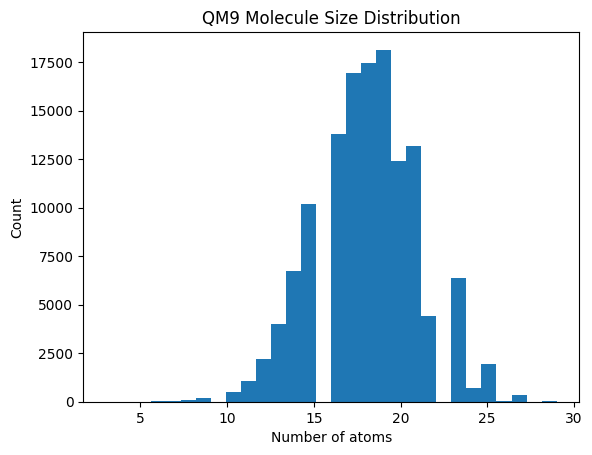

In [ ]:
# Distribution of molecule sizes in the QM9 dataset

import matplotlib.pyplot as plt
import networkx as nx

num_atoms = [data.num_nodes for data in dataset]

plt.hist(num_atoms, bins=30)
plt.xlabel("Number of atoms")
plt.ylabel("Count")
plt.title("QM9 Molecule Size Distribution")
plt.show()

In [40]:
# Atom type distribution

from collections import Counter


atom_counter = Counter()

for data in dataset:
    atom_counter.update(data.z.tolist())

atom_counter

Counter({1: 1208486, 6: 831925, 8: 183265, 7: 132498, 9: 3036})

In [41]:
atomic_numbers = {
    1: "H", 6: "C", 7: "N", 8: "O", 9: "F"
}

for k, v in atom_counter.items():
    print(atomic_numbers[k], v)


C 831925
H 1208486
N 132498
O 183265
F 3036


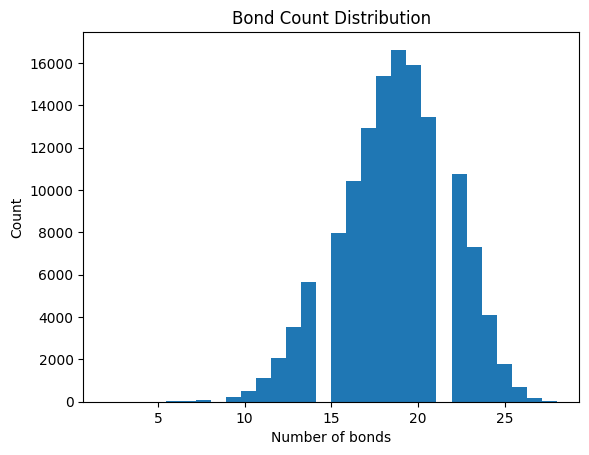

In [ ]:
# Edge / bond statistics 

num_bonds = [data.edge_index.size(1) // 2 for data in dataset]   # This has to be devided by 2 because each bond is represented twice in edge_index

plt.hist(num_bonds, bins=30)
plt.xlabel("Number of bonds")
plt.ylabel("Count")
plt.title("Bond Count Distribution")
plt.show()

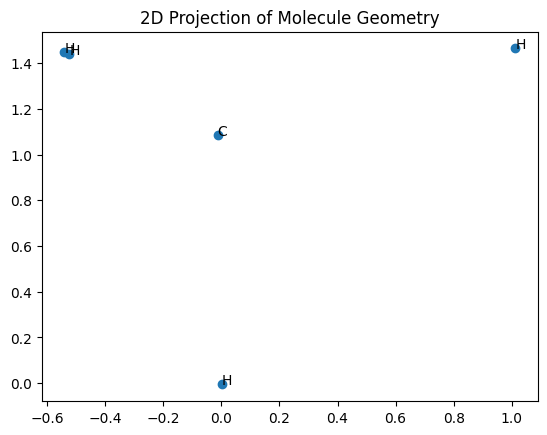

In [44]:
#3D geometry sanity check

data = dataset[0]

pos = data.pos.numpy()
z = data.z.numpy()

plt.scatter(pos[:, 0], pos[:, 1])
for i, atom in enumerate(z):
    plt.text(pos[i, 0], pos[i, 1], atomic_numbers[int(atom)])

plt.title("2D Projection of Molecule Geometry")
plt.show()


In [45]:
# Target (label) exploration

y = torch.cat([data.y for data in dataset], dim=0)
print(y.shape)   #

torch.Size([130831, 19])


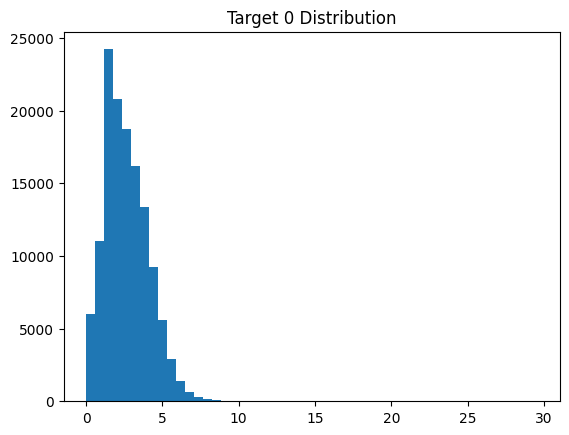

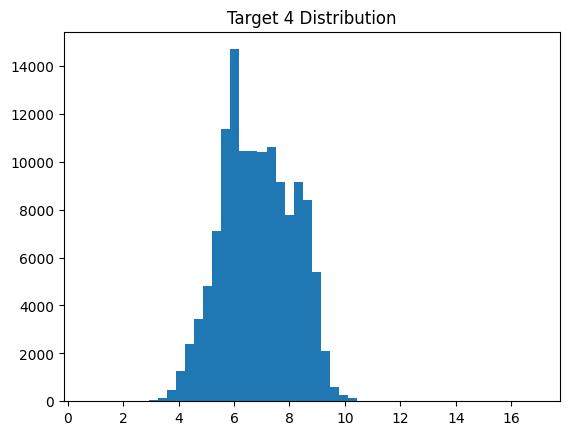

In [46]:
plt.hist(y[:, 0].numpy(), bins=50)
plt.title("Target 0 Distribution")
plt.show()

plt.hist(y[:, 4].numpy(), bins=50)
plt.title("Target 4 Distribution")
plt.show()

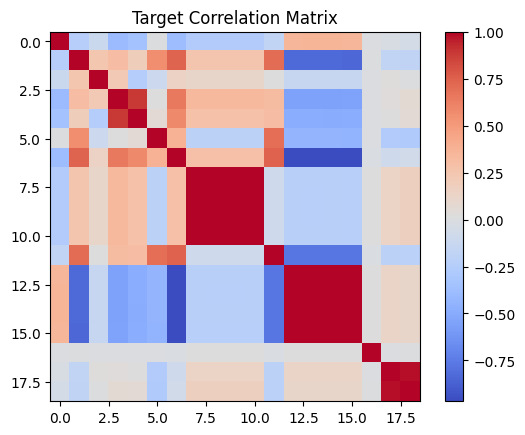

In [47]:
import numpy as np

corr = np.corrcoef(y.numpy().T)

plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.title("Target Correlation Matrix")
plt.show()

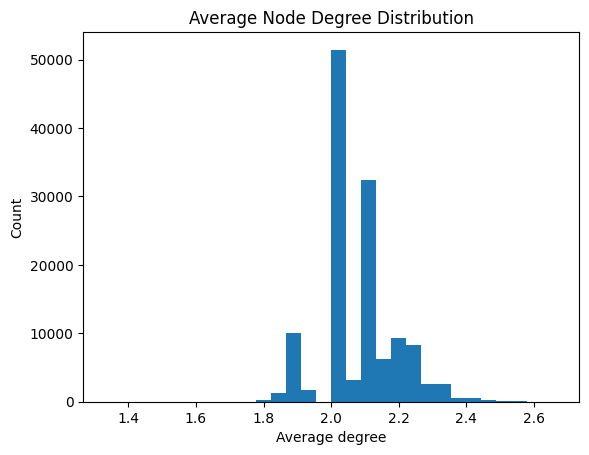

In [48]:
# Graph-level feature sanity checks

avg_degree = []

for data in dataset:
    deg = data.edge_index.size(1) / data.num_nodes
    avg_degree.append(deg)

plt.hist(avg_degree, bins=30)
plt.xlabel("Average degree")
plt.ylabel("Count")
plt.title("Average Node Degree Distribution")
plt.show()


#################################################################

# Graph Neural Network 

##################################################################

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import Chem
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9

# Atom Encoder (Initial Node Embeddings)

In [56]:
class AtomEncoder(nn.Module):
    def __init__(self, in_dim, emb_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, emb_dim)

    def forward(self, x):
        return F.relu(self.linear(x))


# Message Passing Layer 

In [58]:
class SimpleGNNLayer(MessagePassing):
    def __init__(self, emb_dim):
        super().__init__(aggr='add')
        self.msg_lin = nn.Linear(emb_dim, emb_dim)
        self.update_lin = nn.Linear(2 * emb_dim, emb_dim)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return self.msg_lin(x_j)

    def update(self, aggr_out, x):
        h = torch.cat([x, aggr_out], dim=1)
        return F.relu(self.update_lin(h))


# Full GNN Model (Encoder → MP → Readout)

In [62]:
class MoleculeGNN(nn.Module):
    def __init__(self, atom_in_dim, hidden_dim):
        super().__init__()
        self.atom_encoder = AtomEncoder(atom_in_dim, hidden_dim)
        self.gnn1 = SimpleGNNLayer(hidden_dim)
        self.gnn2 = SimpleGNNLayer(hidden_dim)
        self.readout = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        h = self.atom_encoder(x)
        h = self.gnn1(h, edge_index)
        h = self.gnn2(h, edge_index)

        hg = global_mean_pool(h, batch)
        return self.readout(hg)


In [64]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[:10000]
test_dataset  = dataset[10000:12000]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)


# Training Loop 

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MoleculeGNN(
    atom_in_dim=dataset.num_node_features,
    hidden_dim=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()



In [66]:
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        pred = model(data)
        target = data.y[:, TARGET_IDX].unsqueeze(1)

        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


In [67]:
def test():
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)

            pred = model(data)
            target = data.y[:, TARGET_IDX].unsqueeze(1)

            loss = loss_fn(pred, target)
            total_loss += loss.item()

    return total_loss / len(test_loader)


In [69]:
TARGET_IDX = 0  # dipole moment

for epoch in range(20):
    train_loss = train()
    test_loss = test()
    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Test MSE: {test_loss:.4f}")


Epoch 00 | Train MSE: 2.3219 | Test MSE: 1.5739
Epoch 01 | Train MSE: 1.9922 | Test MSE: 1.3717
Epoch 02 | Train MSE: 1.8769 | Test MSE: 1.3304
Epoch 03 | Train MSE: 1.7949 | Test MSE: 1.3787
Epoch 04 | Train MSE: 1.6987 | Test MSE: 1.3503
Epoch 05 | Train MSE: 1.6763 | Test MSE: 1.1696
Epoch 06 | Train MSE: 1.6511 | Test MSE: 1.1869
Epoch 07 | Train MSE: 1.6337 | Test MSE: 1.2153
Epoch 08 | Train MSE: 1.6282 | Test MSE: 1.2265
Epoch 09 | Train MSE: 1.6158 | Test MSE: 1.1659
Epoch 10 | Train MSE: 1.5902 | Test MSE: 1.1991
Epoch 11 | Train MSE: 1.5569 | Test MSE: 1.1606
Epoch 12 | Train MSE: 1.5422 | Test MSE: 1.1213
Epoch 13 | Train MSE: 1.5117 | Test MSE: 1.1353
Epoch 14 | Train MSE: 1.4838 | Test MSE: 1.1336
Epoch 15 | Train MSE: 1.4463 | Test MSE: 1.0926
Epoch 16 | Train MSE: 1.4724 | Test MSE: 1.1330
Epoch 17 | Train MSE: 1.4240 | Test MSE: 1.1119
Epoch 18 | Train MSE: 1.4030 | Test MSE: 1.1504
Epoch 19 | Train MSE: 1.3699 | Test MSE: 1.0746


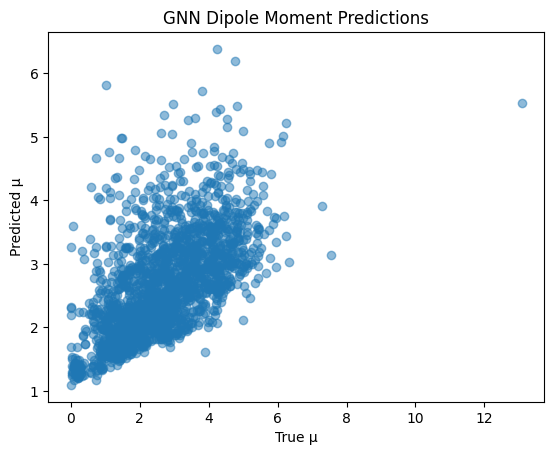

In [70]:
model.eval()
preds = []
targets = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        pred = model(data)
        target = data.y[:, TARGET_IDX].unsqueeze(1)
        preds.append(pred.cpu())
        targets.append(target.cpu())

preds = torch.cat(preds)
targets = torch.cat(targets)

import matplotlib.pyplot as plt
plt.scatter(targets, preds, alpha=0.5)
plt.xlabel("True μ")
plt.ylabel("Predicted μ")
plt.title("GNN Dipole Moment Predictions")
plt.show()
